In [41]:
import pandas as pd
from textblob import TextBlob
import nltk
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import swifter
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
stock_news = pd.read_csv("../data/raw_analyst_ratings.csv", index_col=0)
stock_news.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
# 1. Define the list of tickers and the structure to hold the DataFrames
tickers = ['NVDA', 'AAPL', 'AMZN', 'GOOG', 'META', 'MSFT']
file_extension = ".csv"
stock_data = {}

## ○ Date Alignment: Ensure that both datasets (news and stock prices) are aligned by dates. This might involve normalizing timestamps.
#### Prepare and normalize timestamps for news data and stock data
#### and compine both news adn stock data together

In [4]:
# 2. Load each CSV file into a DataFrame and store it in the dictionary
for ticker in tickers:
    # Construct the expected file name (e.g., 'NVDA.csv')
    filename = "../data/" +ticker + file_extension
    
    try:
        # Load the CSV file:
        # - index_col='Date': Assumes your date column is named 'Date'
        # - parse_dates=True: Converts the date column into datetime objects
        df = pd.read_csv(
            filename, 
            index_col='Date', 
            parse_dates=True
        )
        
        # Store the DataFrame in the dictionary
        stock_data[ticker] = df
        
        print(f" Loaded {filename}. Shape: {df.shape}")
        
    except FileNotFoundError:
        print(f" ERROR: File '{filename}' not found. Check your file path.")
    except Exception as e:
        print(f" ERROR processing {filename}: {e}")

 Loaded ../data/NVDA.csv. Shape: (3774, 5)
 Loaded ../data/AAPL.csv. Shape: (3774, 5)
 Loaded ../data/AMZN.csv. Shape: (3774, 5)
 Loaded ../data/GOOG.csv. Shape: (3774, 5)
 Loaded ../data/META.csv. Shape: (2923, 5)
 Loaded ../data/MSFT.csv. Shape: (3774, 5)


In [6]:
# Work with a copy of the stock_news DataFrame
news = stock_news.copy()

# Convert timestamp to datetime
news['date'] = pd.to_datetime(
    news['date'], 
    format='mixed', 
    utc=True, # Standardizes all times to UTC (essential for merging daily data)
    errors='coerce' # Converts unparseable dates to NaT (Not a Time)
)

# Normalize to date (removes time)
news['date_only'] = news['date'].dt.date

news.head()

,headline,url,publisher,date,stock,date_only
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22


## ○ Sentiment Analysis:
* We will assign a polarity score to each headline:
* polarity > 0 → positive
* polarity < 0 → negative
* polarity == 0 → neutral

In [12]:
def get_sentiment(headline):
    analysis = TextBlob(str(headline))
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([polarity, sentiment])

In [13]:
news[['sentiment_score', 'sentiment_label']] = news['headline'].swifter.apply(get_sentiment)  

Pandas Apply: 100%|██████████| 1407328/1407328 [33:08<00:00, 707.88it/s] 


##### Top five result to see Sentiment score

In [17]:
news.head(10)

,headline,url,publisher,date,stock,date_only,sentiment_score,sentiment_label
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,0.00,neutral
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,0.00,neutral
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,0.00,neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,0.00,neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,0.00,neutral
5,"CFRA Maintains Hold on Agilent Technologies, L...",https://www.benzinga.com/news/20/05/16095163/c...,vishwanath@benzinga.com,2020-05-22 15:23:25+00:00,A,2020-05-22,0.00,neutral
6,"UBS Maintains Neutral on Agilent Technologies,...",https://www.benzinga.com/news/20/05/16094027/u...,vishwanath@benzinga.com,2020-05-22 13:36:20+00:00,A,2020-05-22,0.00,neutral
7,Agilent Technologies shares are trading higher...,https://www.benzinga.com/wiim/20/05/16093805/a...,Benzinga Newsdesk,2020-05-22 13:07:04+00:00,A,2020-05-22,0.25,positive
8,Wells Fargo Maintains Overweight on Agilent Te...,https://www.benzinga.com/news/20/05/16093505/w...,vishwanath@benzinga.com,2020-05-22 12:37:59+00:00,A,2020-05-22,0.00,neutral
9,10 Biggest Price Target Changes For Friday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-05-22 12:06:17+00:00,A,2020-05-22,0.00,neutral


In [18]:
for ticker, df in stock_data.items():
    data = stock_data[ticker]
    # Reset index so Date becomes a column
    data = data.reset_index()
    # Normalize date to match news format
    data['date_only'] = data['Date'].dt.date
    stock_data[ticker] = data


In [53]:
news_and_stock_data = {}
for ticker in tickers:
    stock_df = stock_data.get(ticker)
    if stock_df is not None:
        merged_df = pd.merge(
            news, 
            stock_df, 
            how='inner', 
            on='date_only', 
            suffixes=('_news', f'_{ticker}')
        )
        news_and_stock_data[ticker] = merged_df
        print(f"Merged data for {ticker}. Shape: {merged_df.shape}")
    else:
        print(f"No stock data available for {ticker}.")


Merged data for NVDA. Shape: (1379682, 15)
Merged data for AAPL. Shape: (1379682, 15)
Merged data for AMZN. Shape: (1379682, 15)
Merged data for GOOG. Shape: (1379682, 15)
Merged data for META. Shape: (1111659, 15)
Merged data for MSFT. Shape: (1379682, 15)


##### Quick Visualization of GOOG Daily Sentiment

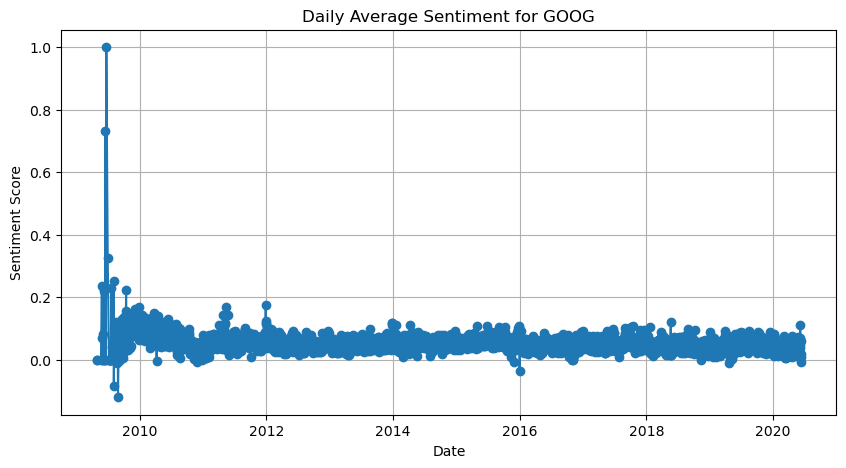

In [21]:
ticker = 'GOOG'
df = news_and_stock_data[ticker]
daily_sentiment = df.groupby('date_only')['sentiment_score'].mean()

plt.figure(figsize=(10,5))
daily_sentiment.plot(kind='line', marker='o')
plt.title(f'Daily Average Sentiment for {ticker}')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

## ○ Analysis:

#### ■ Calculate Daily Stock Returns: Compute the percentage change in daily closing prices to represent stock movements.


In [55]:
for ticker in tickers:
    df = news_and_stock_data[ticker]
    
    # Ensure sorted by date
    df = df.sort_values('Date')
    
    # Daily returns from close prices
    df['daily_return'] = df['Close'].pct_change()

    # Update back to the dictionary
    news_and_stock_data[ticker] = df

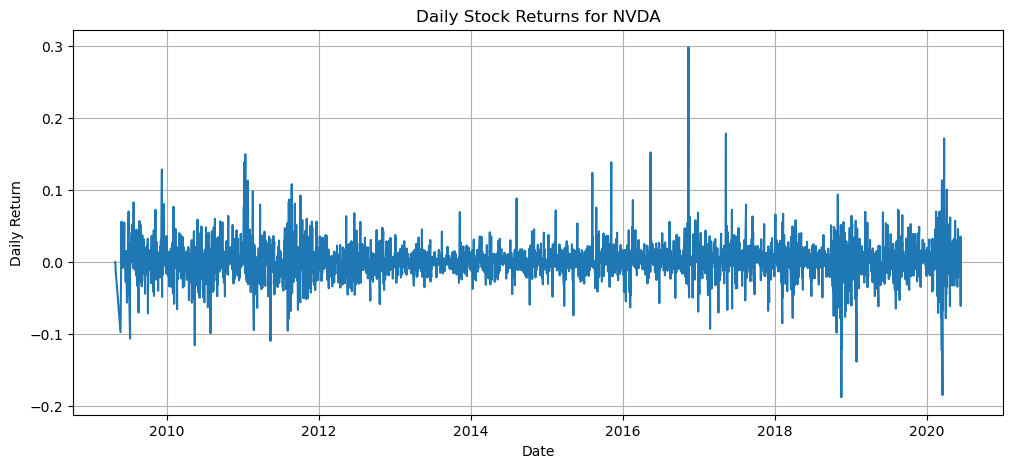

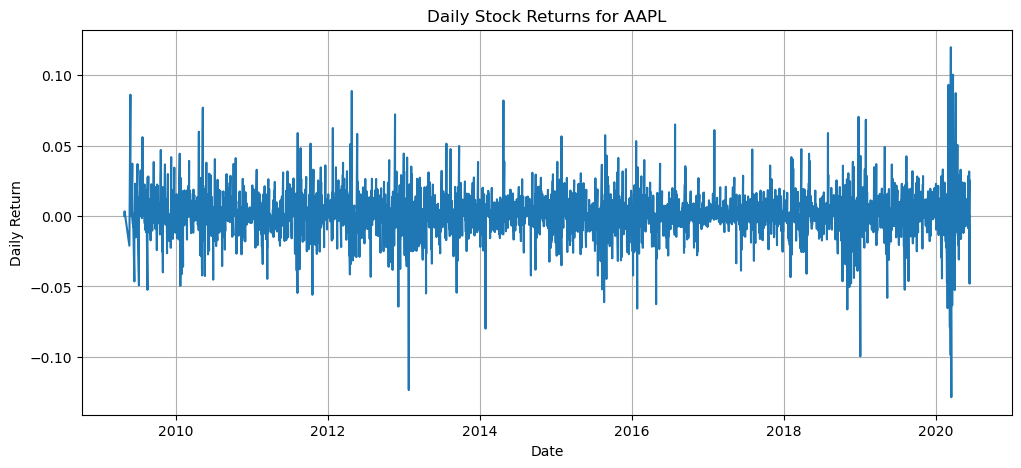

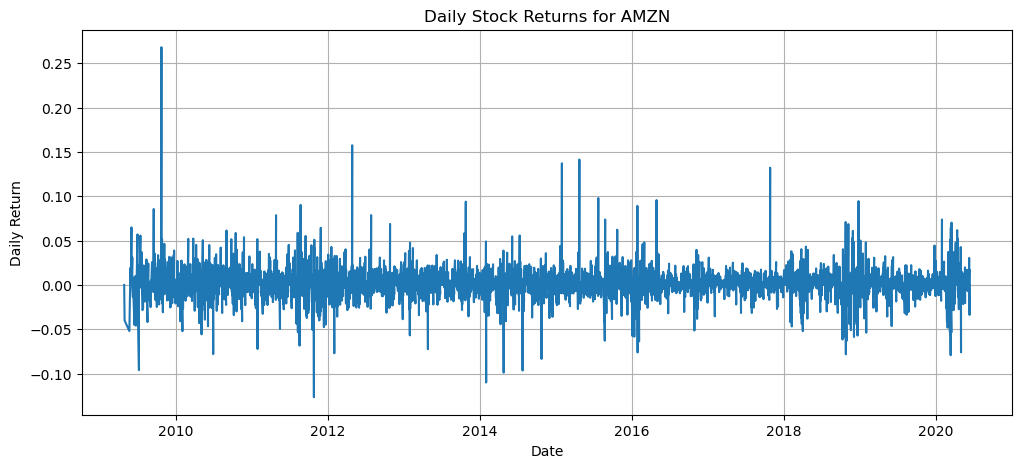

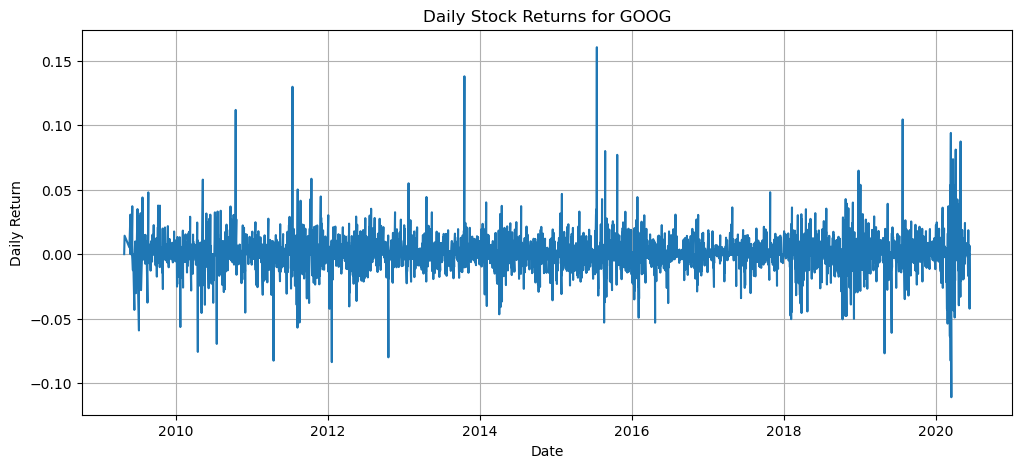

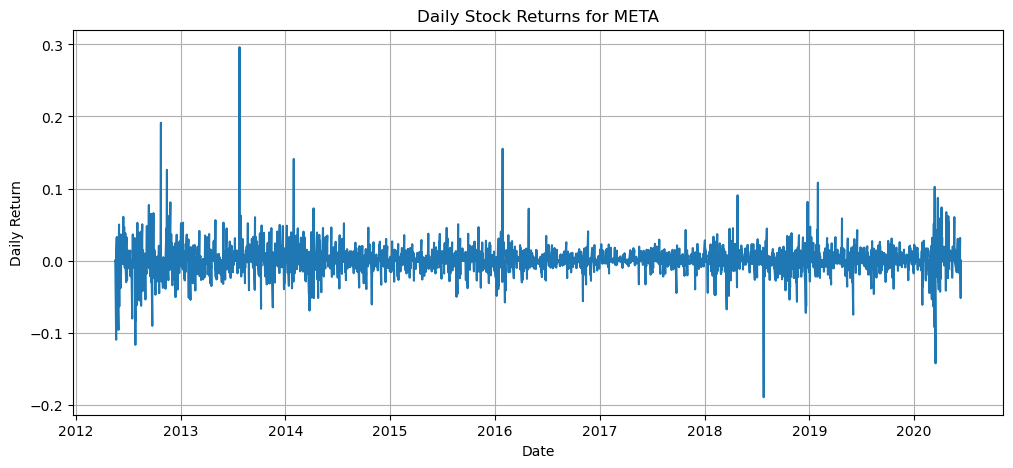

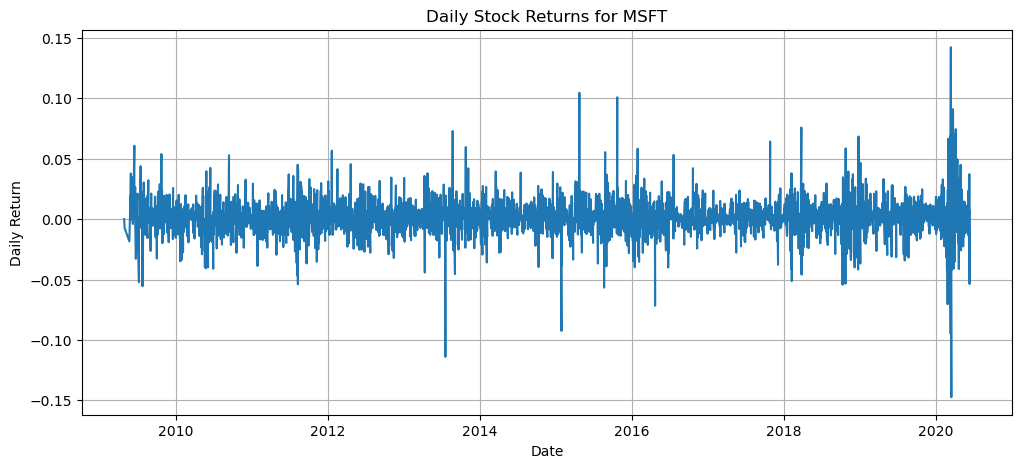

In [31]:
for ticker in tickers:   
    df = news_and_stock_data[ticker]

    plt.figure(figsize=(12, 5))
    plt.plot(df['date'], df['daily_return'])
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.title(f"Daily Stock Returns for {ticker}")
    plt.grid(True)
    plt.show()

### ■ Correlation Analysis: Use statistical methods to test the correlation between daily news sentiment scores and stock returns.


In [56]:
daily_data = {}            # NEW dictionary for merged daily data
correlation_results = {}   # NEW dictionary for correlation values

for ticker in tickers:
    df = news_and_stock_data[ticker]

    # Convert timestamp to date only
    df['date_only'] = df['date'].dt.date

    # Aggregate sentiment per day
    daily_sentiment = (
        df.groupby('date_only')['sentiment_score']
        .mean()
        .reset_index(name='daily_sentiment')
    )

    # Remove duplicate daily_return rows
    daily_stock = (
        df[['date_only', 'daily_return']]
        .drop_duplicates()
    )

    # Merge sentiment + returns
    merged = pd.merge(
        daily_stock, daily_sentiment,
        on='date_only',
        how='inner'
    )

    # Save merged data in new dictionary
    daily_data[ticker] = merged

    # Calculate correlation
    corr = merged['daily_sentiment'].corr(merged['daily_return'])
    correlation_results[ticker] = corr

#### Print correlation results

In [57]:
for ticker, corr in correlation_results.items():
    print(f"{ticker}: {corr:.4f}")

NVDA: -0.0076
AAPL: 0.0460
AMZN: 0.0153
GOOG: 0.0225
META: 0.0577
MSFT: 0.0289
